In [18]:
#mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [19]:
!pip install pretrainedmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 3.1 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=226f5c4c7200cd67d043809da3943aca0e6db49fda0c5693994d770ccb8c8b56
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels


In [20]:
!unzip "/content/gdrive/MyDrive/train_data/dataset_1000.zip"

Archive:  /content/gdrive/MyDrive/train_data/dataset_1000.zip
 extracting: 000000.png              
 extracting: 000000_seg.png          
 extracting: 000000_ldmks.txt        
 extracting: 000001.png              
 extracting: 000001_seg.png          
 extracting: 000001_ldmks.txt        
 extracting: 000002.png              
 extracting: 000002_seg.png          
 extracting: 000002_ldmks.txt        
 extracting: 000003.png              
 extracting: 000003_seg.png          
 extracting: 000003_ldmks.txt        
 extracting: 000004.png              
 extracting: 000004_seg.png          
 extracting: 000004_ldmks.txt        
 extracting: 000005.png              
 extracting: 000005_seg.png          
 extracting: 000005_ldmks.txt        
 extracting: 000006.png              
 extracting: 000006_seg.png          
 extracting: 000006_ldmks.txt        
 extracting: 000007.png              
 extracting: 000007_seg.png          
 extracting: 000007_ldmks.txt        
 extracting: 000008.png   

In [21]:
#install weights and biases for data logging
!pip install wandb
!wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.0 MB/s 
     |████████████████████████████████| 168 kB 44.8 MB/s 
     |████████████████████████████████| 182 kB 42.5 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 166 kB 44.6 MB/s 
     |████████████████████████████████| 166 kB 55.1 MB/s 
     |████████████████████████████████| 162 kB 59.5 MB/s 
     |████████████████████████████████| 162 kB 53.6 MB/s 
     |████████████████████████████████| 158 kB 47.9 MB/s 
     |████████████████████████████████| 157 kB 50.2 MB/s 
     |████████████████████████████████| 157 kB 47.2 MB/s 
     |████████████████████████████████| 157 kB 10.2 MB/s 
     |████████████████████████████████| 157 kB 48.5 MB/s 
     |████████████████████████████████| 157 kB 49.3 MB/s 
     |████████████████████████████████| 157 kB 12.6 MB/s 
     |████████████████████████████

In [22]:
#time all processes to measure network efficiency
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.2 MB/s 
time: 2.04 ms (started: 2022-11-22 04:26:25 +00:00)


**Imports**

In [23]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pretrainedmodels
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.optim as one
import matplotlib
from tqdm import tqdm
from torchvision import transforms
import albumentations
import wandb

time: 2.62 s (started: 2022-11-22 04:26:25 +00:00)


**Config**

In [24]:
#paths
TEST_ROOT_PATH = '/content/gdrive/MyDrive/300W'
TRAIN_ROOT_PATH = '/content'
# hyperparameters
BATCH_SIZE = 32 #could try smaller batch size. If model is still improving in last epoch this can be increased.
LR = 1e-3
EPOCHS = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# train/test split
TEST_SPLIT = 0.1 #for testing without training we want to test on most of the data
# show dataset keypoint plot
SHOW_DATASET_PLOT = True
RANDOM_SEED=42

time: 1.91 ms (started: 2022-11-22 04:26:28 +00:00)


**Utility**

In [25]:
def valid_keypoints_plot(image, outputs, orig_keypoints, epoch=0):
    """
    This function plots the regressed (predicted) keypoints and the actual 
    keypoints after each validation epoch for one image in the batch.
    """
    # detach the image, keypoints, and output tensors from GPU to CPU
    image = image.detach().cpu()
    outputs = outputs.detach().cpu().numpy()
    orig_keypoints = orig_keypoints.detach().cpu().numpy()
    # just get a single datapoint from each batch
    img = image[0]
    output_keypoint = outputs[0]
    orig_keypoint = orig_keypoints[0]
    img = np.array(img, dtype='float32')
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    
    output_keypoint = output_keypoint.reshape(-1, 2)
    orig_keypoint = orig_keypoint.reshape(-1, 2)
    for p in range(output_keypoint.shape[0]):
        plt.plot(output_keypoint[p, 0], output_keypoint[p, 1], 'r.')
        plt.plot(orig_keypoint[p, 0], orig_keypoint[p, 1], 'b.')
    plt.show()
    # plt.close()

def image_keypoints_plot(image, keypoints):
    # detach the image, keypoints, and output tensors from GPU to CPU
    image = image.detach().cpu()
    keypoints = keypoints.detach().cpu().numpy()
    # just get a single datapoint from each batch
    img = image[0]
    keypoint = keypoints[0]
    img = np.array(img, dtype='float32')
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    keypoint = keypoint.reshape(-1, 2)
    for p in range(keypoint.shape[0]):
        plt.plot(keypoint[p, 0], keypoint[p, 1], 'b.')
    plt.show()
    # plt.close()

def dataset_keypoints_plot(data):
    """
    This function shows the image faces and keypoint plots that the model
    will actually see. This is a good way to validate that our dataset is in
    fact correct and the faces align with the keypoint features. The plot 
    will be show just before training starts. Press `q` to quit the plot and
    start training.
    """
    plt.figure(figsize=(10, 10))
    for i in range(9):
        sample = data[i]
        img = sample['image']
        img = np.array(img, dtype='float32')
        img = np.transpose(img, (1, 2, 0))
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        keypoints = sample['keypoints']
        for j in range(len(keypoints)):
            plt.plot(keypoints[j, 0], keypoints[j, 1], 'b.')
    plt.show()
    plt.close()
  

time: 10.5 ms (started: 2022-11-22 04:26:28 +00:00)


**Dataset Class**

In [26]:
def train_test_split(folder_path, split):
  im_list = np.array([])
  for f in os.listdir(folder_path):
    if not '_seg' in f and not '_ldmks' in f and '.png' in f:
      im_list = np.append(im_list, f)
  len_data = len(im_list)
  # calculate the validation data sample length
  valid_split = int(len_data * split)
  # calculate the training data samples length
  train_split = int(len_data - valid_split)
  training_samples = im_list[:train_split]
  valid_samples = im_list[-valid_split:]
  return training_samples, valid_samples

class FaceKeypointTrainDataset(Dataset):
    def __init__(self, samples, path):
        self.data = samples
        self.path = path
        self.resize = 224
        #normalization required for pretrained pytorch networks
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 

    def __len__(self):
        return len(self.data)

    def get_keypoints(self, file_name):
        #remove file extension from file_name
        idx = [idx for idx, x in enumerate(file_name) if x == '.']
        file_name = file_name[:idx[0]]
        #get name of keypoint file
        file_name = TRAIN_ROOT_PATH +  "/" + file_name + "_ldmks.txt"
        #fetch file and extract keypoints as list of tuples
        keypoints = pd.read_csv(file_name, sep=" ", header=None, names=range(1,3))
        keypoints = np.array(keypoints, dtype='float32')
        return keypoints
    
    def __getitem__(self, index):
        image = cv2.imread(f"{self.path}/{self.data[index]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        orig_h, orig_w, channel = image.shape
        # resize the image into `resize` defined above
        image = cv2.resize(image, (self.resize, self.resize))
        # again reshape to add grayscale channel format
        image = image / 255.0
        # transpose for getting the channel size to index 0
        image = np.transpose(image, (2, 0, 1))
        image = torch.tensor(image, dtype=torch.float)
        image = self.normalize(image)
        # get the keypoints
        keypoints = self.get_keypoints(self.data[index])
        # reshape the keypoints
        keypoints = keypoints.reshape(-1, 2)
        # rescale keypoints according to image resize
        keypoints = keypoints * [self.resize / orig_w, self.resize / orig_h]
        return {
            'image': image,
            'keypoints': torch.tensor(keypoints, dtype=torch.float),
        }

class FaceKeypointTestDataset(Dataset):
    def __init__(self, path):
      ind_names = np.array([])
      out_names = np.array([])
      for f in os.listdir(path + "/01_Indoor"):
        if not '.pts' in f:
          ind_names = np.append(ind_names, "/01_Indoor/" + f)
      for f in os.listdir(path + "/02_Outdoor"):
        if not '.pts' in f:
          out_names = np.append(out_names, '/02_Outdoor/' + f)
      self.ind_data = ind_names
      self.out_data = out_names
      self.path = path
      self.resize = 224
      #normalization required for pretrained pytorch networks
      self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 

    def __len__(self):
        return len(self.data)

    def get_300W_item(self, name):
      pathname = self.path + name
      image = cv2.imread(pathname)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      orig_h, orig_w, channel = image.shape
      # resize the image into `resize` defined above
      image = cv2.resize(image, (self.resize, self.resize))
      # again reshape to add grayscale channel format
      image = image / 255.0
      # transpose for getting the channel size to index 0
      image = np.transpose(image, (2, 0, 1))
      image = torch.tensor(image, dtype=torch.float)
      image = self.normalize(image)
      # get the keypoints
      idx = [idx for idx, x in enumerate(pathname) if x == '.']
      keyname = pathname[0:idx[0]] + ".pts"
      keypoints = np.loadtxt(keyname, dtype=float, comments=("version:", "n_points:", "{", "}"))
      # reshape the keypoints
      keypoints.reshape(68, 2)
      # rescale keypoints according to image resize
      keypoints = keypoints * [self.resize / orig_w, self.resize / orig_h]
      return image, torch.tensor(keypoints,dtype=torch.float)

    def get_300W_Data(self):
      np.random.seed(RANDOM_SEED)
      np.random.shuffle(self.ind_data)
      np.random.shuffle(self.out_data)
      #use a randomized 500 ims from outdoor images and a randomized 500 from indoor images
      data = np.append(self.ind_data[0:500], self.out_data[0:500]) 
      return data

time: 23.6 ms (started: 2022-11-22 04:26:28 +00:00)


**Setup Data**

Training sample instances: 900
Validation sample instances: 100


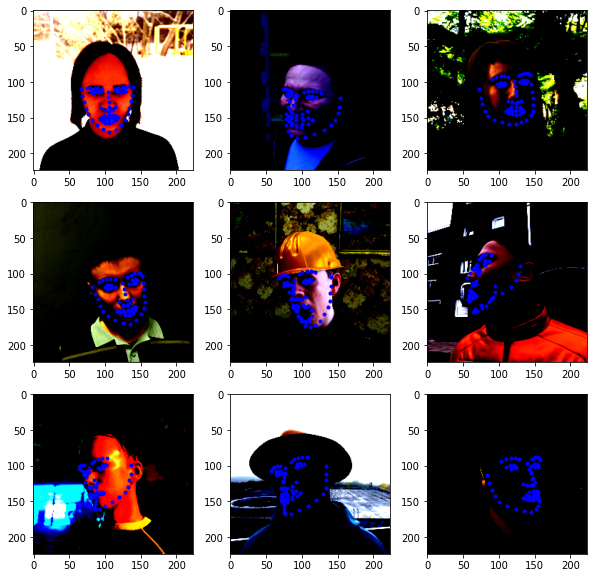

time: 2.54 s (started: 2022-11-22 04:26:28 +00:00)


In [27]:
# get the training and validation data samples
training_samples, valid_samples = train_test_split(f"{TRAIN_ROOT_PATH}", TEST_SPLIT)
# initialize the dataset - `FaceKeypointDataset()`
train_data = FaceKeypointTrainDataset(training_samples, f"{TRAIN_ROOT_PATH}")
valid_data = FaceKeypointTrainDataset(valid_samples, f"{TRAIN_ROOT_PATH}")
# prepare data loaders
train_loader = DataLoader(train_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)
valid_loader = DataLoader(valid_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

print(f"Training sample instances: {len(train_data)}")
print(f"Validation sample instances: {len(valid_data)}")

# whether to show dataset keypoint plots
if SHOW_DATASET_PLOT:
    dataset_keypoints_plot(valid_data)


**Model Class**

In [28]:
class FaceKeypointResNet50(nn.Module):
    def __init__(self, pretrained, requires_grad):
        super(FaceKeypointResNet50, self).__init__()
        if pretrained == True:
            self.model = pretrainedmodels.__dict__['resnet50'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['resnet50'](pretrained=None)
        if requires_grad == True:
            for param in self.model.parameters():
                param.requires_grad = True
            print('Training intermediate layer parameters...')
        elif requires_grad == False:
            for param in self.model.parameters():
                param.requires_grad = False
            print('Freezing intermediate layer parameters...')
        # change the final layer
        self.l0 = nn.Linear(2048, 140)

    def forward(self, x):
        # get the batch size only, ignore (c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        l0 = self.l0(x)
        return l0

time: 3.49 ms (started: 2022-11-22 04:26:31 +00:00)


**Training**

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Training intermediate layer parameters...


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alexmountain. Use `wandb login --relogin` to force relogin


Epoch 1 of 10
Training


29it [00:47,  1.63s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


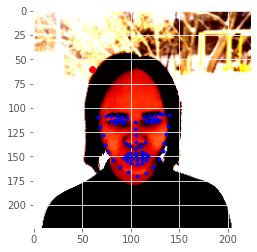

4it [00:04,  1.02s/it]


Train Loss: 97.4799
Val Loss: 61.2634
NME: 2.6203
Epoch 2 of 10
Training


29it [00:42,  1.47s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


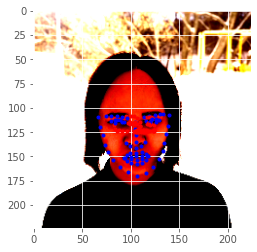

4it [00:04,  1.03s/it]


Train Loss: 38.2794
Val Loss: 20.1651
NME: 1.0324
Epoch 3 of 10
Training


29it [00:39,  1.38s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


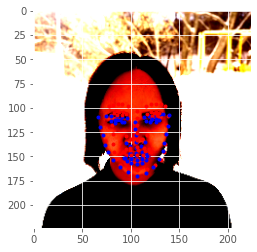

4it [00:04,  1.06s/it]


Train Loss: 14.9491
Val Loss: 13.3899
NME: 0.6886
Epoch 4 of 10
Training


29it [00:40,  1.38s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


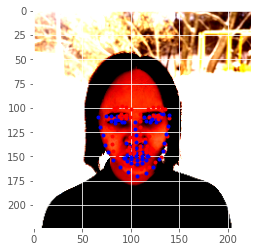

4it [00:03,  1.01it/s]


Train Loss: 13.8013
Val Loss: 13.7601
NME: 0.7179
Epoch 5 of 10
Training


29it [00:41,  1.44s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


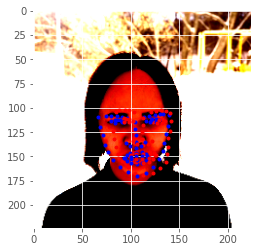

4it [00:04,  1.01s/it]


Train Loss: 13.9361
Val Loss: 12.7591
NME: 0.7231
Epoch 6 of 10
Training


29it [00:39,  1.35s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


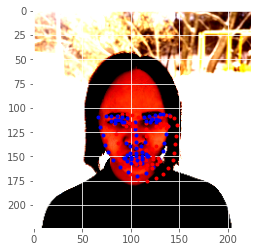

4it [00:04,  1.03s/it]


Train Loss: 13.5533
Val Loss: 12.9071
NME: 0.7054
Epoch 7 of 10
Training


29it [00:40,  1.41s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


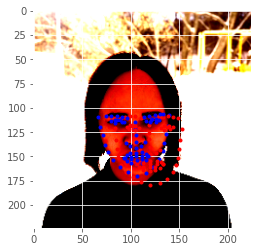

4it [00:03,  1.01it/s]


Train Loss: 13.2229
Val Loss: 12.4071
NME: 0.6978
Epoch 8 of 10
Training


29it [00:38,  1.32s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


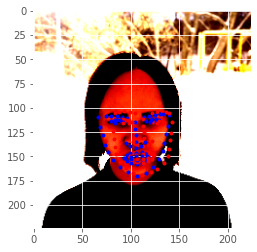

4it [00:03,  1.12it/s]


Train Loss: 12.5974
Val Loss: 12.6106
NME: 0.7520
Epoch 9 of 10
Training


29it [00:36,  1.27s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


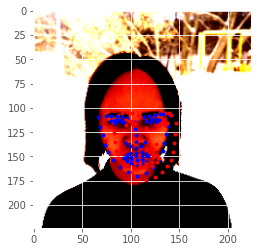

4it [00:03,  1.04it/s]


Train Loss: 12.1130
Val Loss: 12.2394
NME: 0.6578
Epoch 10 of 10
Training


29it [00:38,  1.34s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


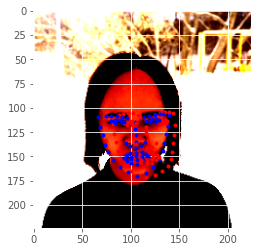

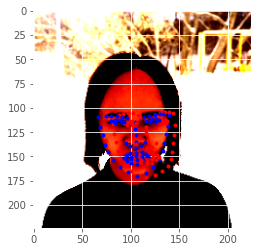

 33%|███▎      | 1/3 [00:01<00:03,  1.57s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


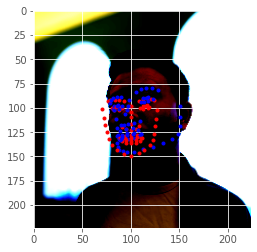

 67%|██████▋   | 2/3 [00:02<00:01,  1.37s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


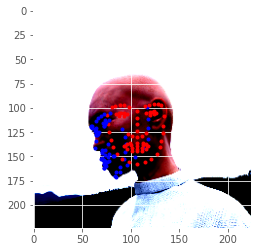

100%|██████████| 3/3 [00:04<00:00,  1.29s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


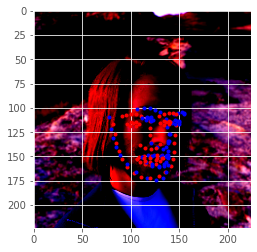

4it [00:04,  1.22s/it]


Train Loss: 11.9778
Val Loss: 11.6728
NME: 0.6655


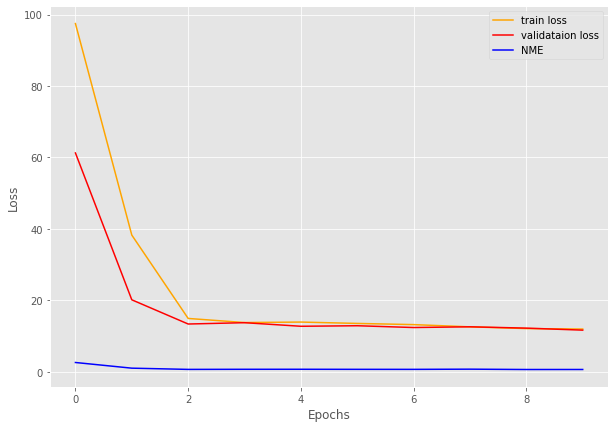

DONE TRAINING
time: 7min 43s (started: 2022-11-22 04:26:31 +00:00)


In [29]:
def compute_nme(preds, target):
    """ preds/target:: numpy array, shape is (N, L, 2)
        N: batchsize L: num of landmark 
    """
    preds = preds.cuda().detach().cpu().clone().numpy()
    target = target.cuda().detach().cpu().clone().numpy()

    preds = preds[:, 0:136]
    
    N = preds.shape[0]
    preds = np.reshape(preds, (N, 68, 2))
    L = preds.shape[1]
    L_targ = target.shape[1]

    if L_targ == 140:
      target = target[:, 0:136]
    target = np.reshape(target, (N, 68, 2))

    rmse = np.zeros(N)

    for i in range(N):
        pts_pred, pts_gt = preds[i, ], target[i, ]
        if L == 68:  # 300w
            # interocular
            interocular = np.linalg.norm(pts_gt[36, ] - pts_gt[45, ])
        else:
            raise ValueError('Number of landmarks is wrong')
        rmse[i] = np.sum(np.linalg.norm(pts_pred - pts_gt,
                                        axis=1)) / (interocular * L)

    return np.mean(rmse)

matplotlib.style.use('ggplot')
#model 
#NOTE: setting pretrained=True and requires_grad=True initializes our weights with pretrained model and then updates our intermediate layers
model = FaceKeypointResNet50(pretrained=True, requires_grad=True).to(DEVICE)
#optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)
# we need a loss function which is good for regression like SmmothL1Loss ...
# ... or MSELoss
criterion = nn.SmoothL1Loss() #TODO test both MSELoss and SmoothL1Loss

# training function
def fit(model, dataloader, data):
    print('Training')
    model.train()
    train_running_loss = 0.0
    counter = 0
    # calculate the number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    for i, data in tqdm(enumerate(dataloader), total=num_batches):
        counter += 1
        image, keypoints = data['image'].to(DEVICE), data['keypoints'].to(DEVICE)
        # flatten the keypoints
        keypoints = keypoints.view(keypoints.size(0), -1)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, keypoints)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/counter
    return train_loss 

# validatioon function
def validate(model, dataloader, data, epoch):
    print('Validating')
    model.eval()
    valid_running_loss = 0.0
    counter = 0
    # calculate the number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=num_batches):
            counter += 1
            image, keypoints = data['image'].to(DEVICE), data['keypoints'].to(DEVICE)
            # flatten the keypoints
            keypoints = keypoints.view(keypoints.size(0), -1)
            outputs = model(image)
            loss = criterion(outputs, keypoints)
            nme = compute_nme(outputs, keypoints)
            valid_running_loss += loss.item()
            # plot the predicted validation keypoints after every...
            # ... predefined number of epochs\
            if (epoch+1) % 1 == 0 and i == 0:
                valid_keypoints_plot(image, outputs, keypoints, epoch)
            if epoch+1 == EPOCHS:
                valid_keypoints_plot(image, outputs, keypoints, epoch)
        
    valid_loss = valid_running_loss/counter
    return valid_loss, nme

# Do training and validation

wandb.init(project="resnet50_domain_gap")
wandb.config = {
  "learning_rate": LR,
  "epochs": EPOCHS,
  "batch_size": BATCH_SIZE
}
wandb.watch(model, criterion, log="all", log_freq=1) #TODO might want to change log_freq?

best_val_loss = 1000
# Want to test without training: do validation for a small number of epochs
train_loss = []
val_loss = []
nme = []
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = fit(model, train_loader, train_data)
    val_epoch_loss, nme_val = validate(model, valid_loader, valid_data, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    nme.append(nme_val)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')
    print(f'NME: {nme_val:.4f}')
    wandb.log({"epoch": (epoch+1),
               "train_loss": (train_epoch_loss),
               "val_loss": (val_epoch_loss),
               "NME": (nme_val)})
    wandb.define_metric("epoch")
    if val_epoch_loss < best_val_loss:
      best_val_loss = val_epoch_loss
      torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'sample_data/resnet50_1000.pt')


# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.plot(nme, color='blue', label='NME')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print('DONE TRAINING')


**Testing Phase**

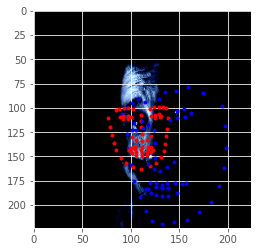

0.5891997999397804
1.1203950748110663
1.6440351274455345
1.992780864975334
0.5278551462254025
2.720915061922466
7.935500416965955
18.977438865227107
0.6372297157038053
1.2778125794669957
0.2985931114266497
3.423038167374744
0.9554002386984517
0.5334958247901668
4.691205379008554
1.0251499312447836
1.2849229399292732
3.2200369137073053
11.698571297381092
6.596661516175971


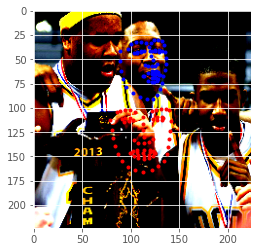

2.608554771138898
10.280330801124594
0.43169563096747865
0.22792133958781255
8.721872699917105
0.42362054508352803
0.34573761053904734
0.47482382147255603
30.06425964754052
6.3316713322522284
0.9427702032968565
5.109182053000709
0.382144462250116
0.6679104995482688
2.9250154281695515
12.211733421389475
2.0915951279688056
5.8910508239531225
2.362480300228963
1.7929643322968287


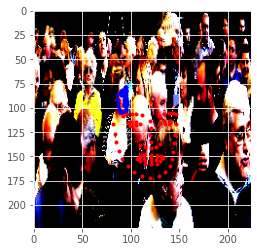

8.261705784725104
3.679197965478933
0.4977459209249357
0.4801589344314163
2.6164454513596738
0.8827954446850171
1.092746618231612
0.9230451859527654
4.6300525954106275
0.4343021893582283
10.375434849400829
24.55122068121301
3.5049568193100322
0.807658751711296
0.38161418719637324
0.9210483884772338
7.890359711319128
12.97548417320104
7.20145563093094
2.0368792786540952


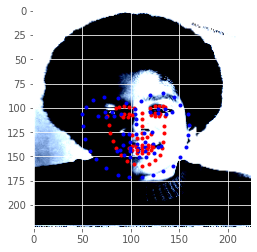

0.16601888009264693
0.3972634177209756
3.506828481318752
0.5956389423212567
0.9022645435230382
1.07971341335387
1.566625912834886
0.7582149231853806
1.5745184319579424
0.87429770702963
10.141831181398699
11.326615765312043
1.1022712284510705
6.263969456533498
9.241692390761203
0.35588752139121943
0.5690659259792973
2.653735119917763
4.437090996541451
0.7911108729255845


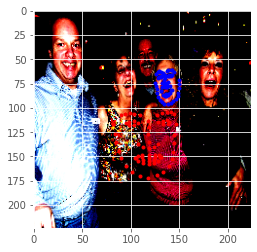

4.1661385021565955
11.87282511178435
0.7586069827029028
13.577122455701545
3.5199570566143543
5.423349313191925
7.6258806182887415
1.3584687021070552
0.6828232718066093
2.486387029671052
4.588977034887978
13.231694753387703
0.6692512744603271
0.8647552012210546
4.781126823941273
0.5055318441044496
11.288376647085954
7.81139848787295
1.1449114994870686
2.717198520585635


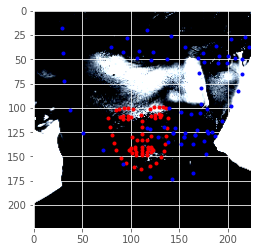

0.556554615918654
7.80154083808477
0.7483248094487728
0.5631243630681309
0.6152761219560273
0.3707787247020989
5.177622035897601
0.8425575345896636
5.709612206935691
13.478565366154298
0.7722022362452658
2.312681593170121
0.7673575378513627
0.41723375262537143
0.3008573542333347
3.1108631623731
10.526524425354209
0.2346373152588318
8.080406748631347
0.5757224091585136


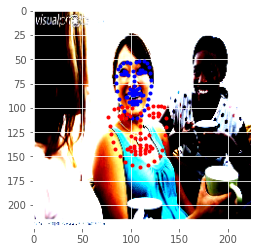

1.9773330504197923
1.1178632638969466
4.62819051119858
2.761448775898766
5.237095603967637
1.7267477825773008
0.7385958510172025
12.938771074117044
5.986205676891844
0.28027696929908585
3.57655983268947
5.813493229781886
3.680651017578832
4.402551864402888
1.2335697376275494
0.3219252322121253
1.4931268673401494
0.5387951890942709
2.878606783653842
1.0849974624597585


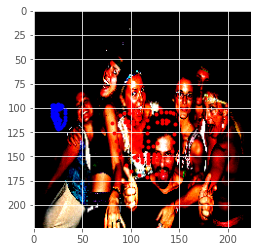

11.222704919067866
8.795265350246112
0.8569193366624844
11.992534217849817
0.5536759369773141
2.9210418622449166
6.162848020893778
2.7337848876834165
0.42119083718175787
0.31234529875432254
0.8387286733524808
6.29455713338055
0.6288654169640573
2.1075830109925002
0.2930147742984534
0.643702399324795
1.101273436383779
0.3193426535446011
5.980924636584881
0.6410258793617957


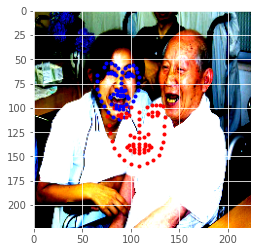

1.9103087726861014
7.294962742433006
3.9625425105652754
1.1858705793213873
2.0821028449444565
17.401375211829674
0.7535207711983326
1.1159195012858467
1.1040782260025932
9.459456445022175
6.775150583028059
0.2526561991584358
0.5521207671718863
0.30804700881616176
8.059357300676373
2.188974904528309
1.940346956884371
2.7653560175283456
0.5331796776424826
10.302046706913458


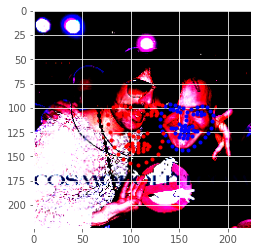

1.4266449124306586
1.6689401645242044
1.6758473527523854
1.0408182080574953
2.821592976154984
1.4390889140686547
0.29853846624163316
0.6083133534906399
8.561784145870323
0.17519940046902274
0.3584379233635632
3.4433705533364263
7.139258785636836
1.0859106132772711
0.4356316955567153
4.5136706321407924
0.39678227879092653
0.49515164606356293
1.2594277655520425
3.3868734865849883


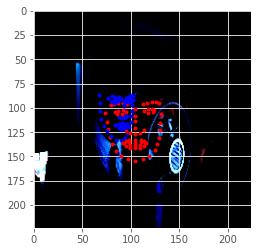

1.0528674489920256
9.130619690462924
0.33830140354003935
0.4278811785209211
4.850206959363271
0.6361524842182514
0.9312194066895981
4.251060061407134
0.5790520217240054
0.8409294247664335
9.205109205888421
0.3679105748774986
3.4276696561886775
7.28768198524517
0.2587185579966509
1.6475772365116825
0.5031213796300098
0.6225302024116752
0.9111870769067616
0.5946701324716792


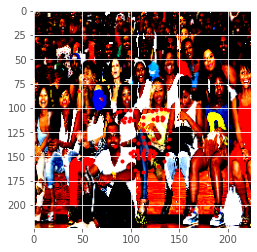

11.076930662624667
0.3613997797219929
0.7651525999022044
3.303015907088408
0.32138850883923376
1.193126453888956
9.208387438186927
4.813580990279184
0.38739985776034597
2.8154491062654707
0.2788093836191614
0.5245482701609522
1.3895863582430965
5.0281566390535
1.0045348737211839
2.5238462358565696
0.3636024883169372
13.03594701371482
3.3515362805616027
0.4704425724225313


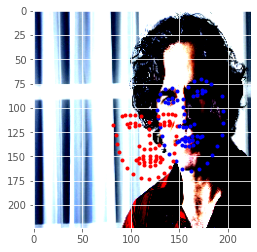

1.070062837967553
0.3191722087411748
5.061759196816457
0.5079487251338319
0.7936160809151769
11.084148662785243
4.381756003736334
0.40845121514698046
1.0140937703401625
1.4680087285906998
16.56365616773534
4.769081307268282
0.6701305480353646
4.103280467907131
0.36974942999178817
3.4790210304488443
1.3514528766719491
2.653114961986286
0.3848914405803992
0.4218284087783411


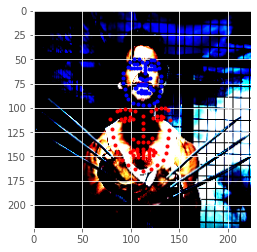

2.2754323964767877
5.886666598586322
0.3455352944743337
2.282468472461099
2.898371437502257
1.5660132671937848
0.5571316165133061
0.3860963602917616
1.459620300876971
0.5740517562146124
4.274110030481462
5.840200973608518
0.3015158053957672
7.620485135878907
0.3582408921100455
12.193360301695117
0.5562715470896816
0.9345680641530634
2.011346786680237
0.7593323509846321


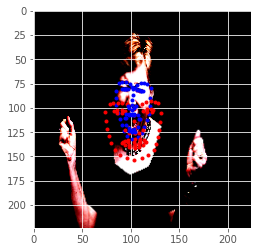

1.0778754418081349
0.292049668079229
7.3084213369160365
0.487120050132687
3.3418246414365056
1.1393498295579791
1.0058050426931289
6.293618155434686
4.005126122611763
4.625160470426866
8.727299728849001
1.0671064425551058
9.414601210300013
2.511598295000168
1.8353585962029915
4.691025939836544
7.231991012321573
8.401361716986642
0.7361487674835692
7.678202169047131


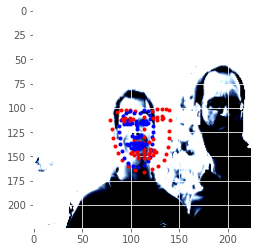

0.41031599817149184
12.953623500965751
1.8255655753722564
3.6578940356021237
12.38199296094628
0.8659982718342705
12.43487492906349
0.8524216101660695
1.2420510912367533
1.3834634561344312
1.5472517311954375
2.9604634096671605
6.385968151138287
4.903714102450221
9.482519988010825
3.133289334029601
1.3277860795764578
9.00926290941358
12.35596428713224
1.9291148436747911


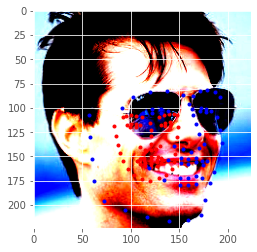

0.5645100447285648
12.912281939077287
6.693804251993663
0.4514695236035876
1.514476676960185
21.67193048771489
0.9215877238967154
0.4188692211330348
0.6171418764554827
9.692156070578982
2.3262533372382523
5.982915996343141
0.594164946593455
10.023020177357974
3.066824576134476
1.7609403441292135
0.8456380278589855
3.670083400619268
0.5822502252263768
2.2038443666603587


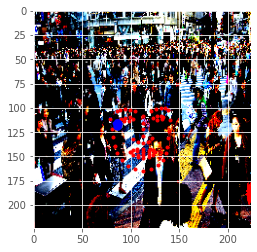

10.14145042868315
2.314043672686791
11.450456744386079
2.766600597490921
8.078952278884444
12.757255125646072
1.6337674792471577
7.334122261088475
2.0497395503081983
6.3332525795917585
0.2880843156268911
0.6337225077020755
4.956688833317638
0.9210117756787884
11.009727486270299
0.5612616702911011
1.5077734114064996
7.293982613161292
2.223894605012745
17.20594531607702


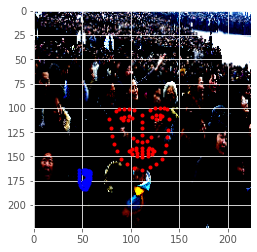

11.328620938999812
8.424710843722423
8.525623972658884
0.4364091952491499
3.1604858863455196
19.148747342043706
3.2558786752865303
0.44718652642972695
0.5937304775362829
28.864654310052284
8.478631686186123
8.438532545102099
2.0248962361720277
14.044606318976134
1.9977836640381192
1.9010246172357483
3.713854177193608
7.90844212097009
3.401088824281086
4.396997539503981


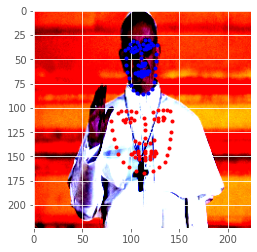

3.9126459252159305
1.6419384196496938
3.832761030976141
1.5348998452465055
7.937854524781923
3.200885867689164
0.44708902118672755
5.535138018317168
11.47699314690555
0.5205160733531916
4.364011847250665
5.2198977126143635
3.367697758406283
9.42464988112429
10.807872534670825
8.914603232671725
6.088983256720543
8.019862687261755
4.875058306805931
4.280977721212234


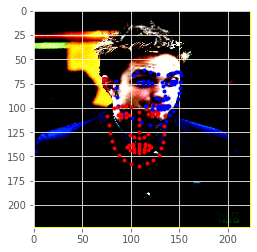

1.1009322215922308


KeyboardInterrupt: ignored

time: 5min 26s (started: 2022-11-22 04:34:15 +00:00)


In [30]:
#Run model on test data from 300WLPA dataset and report NME

#model.load_state_dict(torch.load('sample_data/resnet50_1000.pt')['model_state_dict'])
testdata = FaceKeypointTestDataset(TEST_ROOT_PATH)
dataframe = testdata.get_300W_Data()
nme = []
count = 0
for n in dataframe:
  image, keypoints = testdata.get_300W_item(n)
  image = torch.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]))
  image = image.to(DEVICE)
  keypoints = torch.reshape(keypoints, (1, keypoints.shape[0], keypoints.shape[1]))
  outputs = model(image)
  outputs = outputs[:, 0:136]
  if count % 20 == 0:
    valid_keypoints_plot(image, outputs, keypoints)
  nme_val = compute_nme(outputs, keypoints)
  print(nme_val)
  nme.append(nme_val)
  count += 1


nme = np.array(nme)
print("Average NME: " + str(np.mean(nme)))

**Video Integration**

If this doesn't work in colab then run it locally by downloading the model after training 

(download will take a while unfortunately).

You will also require the above code that handles hyperparameter configuration and the code that defines our model class

In [ ]:
#Imports required for running video locally:
import torch
import torch.nn as nn
import numpy as np
import cv2
from torchvision import transforms
import pretrainedmodels

In [ ]:
model = FaceKeypointResNet50(pretrained=False, requires_grad=False).to(DEVICE)
checkpoint = torch.load('sample_data/my_model_1000.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

#capture the webcam
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
if cap.isOpened()==False:
  print('Error while trying to open webcam. Please check again...')

# get the frame width and height
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# set up the save file path
save_path = "sample_data/vid_keypoint_detection.mp4"
# define codec and create VideoWriter object 
out = cv2.VideoWriter(f"{save_path}", 
                      cv2.VideoWriter_fourcc(*'mp4v'), 20, 
                      (frame_width, frame_height))
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 

while(cap.isOpened()):
    # capture each frame of the video
    ret, frame = cap.read()
    if ret == True:
        with torch.no_grad():
            image = frame
            image = cv2.resize(image, (224, 224))
            orig_frame = image.copy()
            orig_h, orig_w, c = orig_frame.shape
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image / 255.0
            image = np.transpose(image, (2, 0, 1))
            image = torch.tensor(image, dtype=torch.float)
            image = norm(image)
            image = image.unsqueeze(0).to(DEVICE)
            outputs = model(image)
        outputs = outputs.cpu().detach().numpy()
        outputs = outputs.reshape(-1, 2)
        keypoints = outputs
        for p in range(keypoints.shape[0]):
            cv2.circle(orig_frame, (int(keypoints[p, 0]), int(keypoints[p, 1])),
                        1, (0, 0, 255), -1, cv2.LINE_AA)
        orig_frame = cv2.resize(orig_frame, (frame_width, frame_height))
        cv2.imshow('Facial Keypoint Frame', orig_frame)
        out.write(orig_frame)
        # press `q` to exit
        if cv2.waitKey(27) & 0xFF == ord('q'):
            break
 
    else: 
        break